# Inferring Sizes from Continuum Visibilities

I figured that I would show the full workflow in a notebook, but you probably want to pull code from here and re-package it in real python scripts for future flexibility (and readability).  This will be long, but hopefully it is intelligible to some degree.

The first thing we need to do is make sure the data are packaged and parsed in a way that makes sense.  There is flexibility here in packaging (the code does not care how this is done), so long as it is parsed correctly upon being loaded.  When I worked on the [Lupus disks](https://ui.adsabs.harvard.edu/abs/2018ApJ...865..157A/abstract), I used a **CASA** script to export the visibilities directly from the MS into a numpy save file (.npz).  But I think it would probably make more sense to simply use a UVFITS file generated from **CASA**/*exportuvfits* for each source (make sure at some point to *split* off a MS with keepflags=False, so you don't include any flagged data).

In [2]:
import os, sys, time
import numpy as np
from astropy.io import fits
import emcee
import corner
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["OMP_NUM_THREADS"] = "1"    # this is needed for multithreading

# load the UVFITS datafile
target = 'Sz111'
dat = fits.open(target+'.calibrated.uvfits')
data = np.squeeze(dat[0].data)
header = dat[0].header

# in my experience, the 'exportuvfits' command in CASA always fucks up the frequencies
# so I manually enter them here (see in listobs); ideally, one could use the header, but...
freqs = np.array([328.2846840, 339.9833709, 341.785322]) * 1e9

# (u,v) coordinates in **lambda** units
data_u = np.outer(data['UU'], freqs)
data_v = np.outer(data['VV'], freqs)

# average the polarizations (optional; could also flatten the pol dimension and fit everything with a little work)
data_VV_raw = np.squeeze(data['data'])
data_real = 0.5 * (data_VV_raw[:,:,0,0] + data_VV_raw[:,:,1,0])
data_imag = 0.5 * (data_VV_raw[:,:,0,1] + data_VV_raw[:,:,1,1])
data_wgts = (data_VV_raw[:,:,0,2] + data_VV_raw[:,:,1,2])
data_VV = data_real + 1.0j * data_imag

# data_u, data_v, data_VV (complex visibilities) and data_wgts (weights) are all Nvis x Nchan arrays
# one could *either* average spectrally or keep everything and flatten the arrays; here I've done the latter
dat_u = data_u.flatten()
dat_v = data_v.flatten()
dat_vis = data_VV.flatten()
dat_wgt = data_wgts.flatten()

So now we have the data extracted.  We're going to model it assuming there's no spectral variation in the emission (although you could change that...it shouldn't matter much).  I like to pack this up into an object, which you can do like this:

In [3]:
class Visibility:
    def __init__(self, vis, u, v, wgt):
        self.vis = vis 
        self.u = u 
        self.v = v 
        self.wgt = wgt

dvis = Visibility(dat_vis, dat_u, dat_v, dat_wgt)

The model I used in the 2018 sizes paper has 9 free parameters, $\vec{\theta} = \{F_\nu, \varrho_t, \alpha, \beta, \gamma, i, \varphi, dx, dy\}$.  The first five of these are associated with the Nuker profile that defines the surface brightness model, where

$$I_\nu(\varrho) \propto \left(\frac{\varrho}{\varrho_t}\right)^{-\gamma} \left[1 + \left(\frac{\varrho}{\varrho_t}\right)^\alpha \right]^{(\gamma-\beta) / \alpha}.$$

In order of the code, these are the normalization factor (here set in terms of the total flux density $F_\nu$, defined as $\int I_\nu(\varrho) \, 2 \pi \, \varrho \, d\varrho$) in Jy, the turnover radius $\varrho_t$ in arcseconds, and the indices $\alpha$ (actually we use $\log_{10}{\alpha}$), $\beta$, and $\gamma$.  Then we have the disk inclination $i$, position angle of the major axis $\varphi$, and the right ascension and declination offsets from the phase center $dx, dy$.  

Before setting up the likelihood function, etc., we can initialize the MCMC setup by drawing random parameter values in this set.

In [4]:
# boundaries of initial parameter draws
# (nominally these don't matter, but things move faster if you make a decent guess based on e.g., the image)
# (in this particular case, these are awful guesses because I'm lazy: it works out)
p_lo = np.array([0.025, 0.25, 0.0, 4., 1.0, 40.,  80., -0.1, -0.1])
p_hi = np.array([0.035, 0.50, 1.0, 8., 1.5, 60., 110.,  0.1,  0.1])

# initial draws
ndim, nwalk = len(p_lo), 5 * len(p_lo)
p0 = [np.random.uniform(p_lo, p_hi, ndim) for i in range(nwalk)]

Now the important part: the actual model function.

This may seem a little weird, but it works quite well and is considerably faster and more accurate than the standard approach of generating an image and sampling its FFT.  The idea is to first compute a discrete model of the intensity profile, where $I_\nu(\varrho)$ is constant in each of a set of radial bins.  The bins can in principle be chosen freely, but for most problems of interest here (e.g., power-law-ish functions), you win considerably in both speed and accuracy if you distribute the bins logarithmically.  (This is simply because such a distribution more naturally covers the full range of relevant spatial scales.  If you were to use an image, you would need very small pixels covering a large radial extent to preserve accuracy, which would necessarily be slow.  The alternative is to compute weird images in more clever ways, like in [this paper](https://ui.adsabs.harvard.edu/abs/2014MNRAS.440.3285B/abstract).)

A nice feature of this discretized approach is that the model is just a linear combination of "top-hat" functions, where the *coefficients* are the intensities in each radial bin.  This has an analytic Fourier (Hankel) transform (presuming you consider Bessel functions "analytic") that is pretty easy to compute quickly.  The mathematical motivation for this model is described in [this notebook](https://github.com/seanandrews/D3SB/blob/master/notebooks/concepts.ipynb), and the practical implementation is explained in [this notebook](https://github.com/seanandrews/D3SB/blob/master/notebooks/how%20D3SB%20works.ipynb), if those things are of interest (both from long-abandoned projects focused on other things).  

In [5]:
import scipy.special as sc

def vis_model(theta, uv):
    
    # parse the parameter values
    Ftot = theta[0]
    rt = theta[1]
    alp = 10**theta[2]
    bet = theta[3]
    gam = theta[4]
    incl = np.radians(theta[5])
    PA = 0.5 * np.pi - np.radians(theta[6])
    dx = theta[7] * np.pi / (180 * 3600)
    dy = theta[8] * np.pi / (180 * 3600)
    
    # create a set of radial bins
    nbins = 150
    b = np.logspace(-3, 1, num=nbins)    # bin outer edges
    a = np.roll(b, 1)                    # bin inner edges
    rin = 0.1/140.                       # innermost bin's inner edge
    a[0] = rin
    cb = 0.5*(a+b)                       # bin centers
    bins = rin, b

    # compute the un-normalized model intensity profile at those bin centers (cb)
    SB_0 = (cb / rt)**(-gam) * (1 + (cb / rt)**alp)**((gam - bet) / alp)

    # normalize the intensity profile
    Inu = Ftot * SB_0 / np.trapz(2 * np.pi * SB_0 * cb, cb)
    
    # unpack (u,v) positions
    u, v = uv
    
    # coordinate change to deal with projection and rotation
    uprime = u * np.cos(PA) + v * np.sin(PA)
    vprime = (-u * np.sin(PA) + v * np.cos(PA)) * np.cos(incl)
    rho = np.sqrt(uprime**2 + vprime**2) * np.pi / (180 * 3600)

    # re-orient radius and intensity arrays
    rbin = np.concatenate([np.array([rin]), b])
    Ibin = np.append(np.concatenate([np.array([0.0]), Inu]), 0.)
    II = Ibin - np.roll(Ibin, -1)
    intensity = np.delete(II, b.size + 1)
    
    # compute the visibilities (a summation of Hankel transforms for each intensity annulus)
    jarg = np.outer(2 * np.pi * rbin, rho)
    jinc = sc.j1(jarg) / jarg
    vis = np.dot(2 * np.pi * rbin**2 * intensity, jinc)

    # impart a phase center shift
    shift = np.exp(-2 * np.pi * 1.0j * ((u * -dx) + (v * -dy)))
    mvis = vis * shift

    return mvis

Ok, now here is one of the practical changes in the newer **emcee** version.  The multithread parallelization is worse than serial if you have large pass-able keywords to the likelihood function (i.e., the data).  So, the trick is that we have to make the data a global variable

In [6]:
global dvis_pass
dvis_pass = dvis

Now we can define the (log) posterior function (including both priors and likelihoods):

In [7]:
def lnprob(theta):

    # PRIORS

    # p(Ftot) = uniform(0, 10 Jy)
    if ((theta[0] < 0.) or (theta[0] > 10.)):
        return -np.inf

    # p(r_b) = uniform(0.01, 10 arcseconds) 
    if ((theta[1] < 0.01) or (theta[1] > 10.)):
        return -np.inf

    # p(log alpha) = uniform(0, 2)
    if ((theta[2] < 0.0) or (theta[2] > 2.0)):
        return -np.inf

    # p(beta) = uniform(2, 10)
    if ((theta[3] < 2.0) or (theta[3] > 10.)):
        return -np.inf

    # p(gamma) = double-sided logistic
    if ((theta[4] > -5.) and (theta[4] < 2.5)):
        prior_g = 1./(1.+np.exp(-5.*(theta[4]+3.))) - \
                  1./(1.+np.exp(-15.*(theta[4]-1.75)))
    else: return -np.inf

    # p(i) = sin(i) 
    if ((theta[5] > 0.) and (theta[5] < 90.)):
        prior_i = np.sin(np.radians(theta[5]))
    else: return -np.inf

    # p(PA) = uniform(0, 180)
    if ((theta[6] < 0.) or (theta[6] > 180.)):
        return -np.inf
    
        # p(dx) = uniform(-3, 3)
    if ((theta[7] < -3.) or (theta[7] > 3.)):
        return -np.inf

    # p(dy) = uniform(-3, 3)
    if ((theta[8] < -3.) or (theta[8] > 3.)):
        return -np.inf

    # calculate a log-likelihood
    uv = dvis_pass.u, dvis_pass.v
    mvis = vis_model(theta, uv)
    loglike = -0.5 * np.sum(dvis_pass.wgt * np.absolute(dvis_pass.vis - mvis)**2)

    # return a posterior sample
    return loglike + np.log(prior_g) + np.log(prior_i)

Now we're ready to set up the MCMC inference framework.  First, we'll set things up to save into an HDF5 file in case (a) the job dies; or (b) you want to continue beyond the defined number of steps.

In [141]:
# set up an HDF5 backend
h5_filename = target + '.h5'
os.system('rm -rf ' + h5_filename)
backend = emcee.backends.HDFBackend(h5_filename)
backend.reset(nwalk, ndim)

Then we will set up the MCMC to run for a fixed 'max_steps' steps, or until we meet some convergence criteria associated with the autocorrelation times (i.e., that the mean autocorrelation time, measured every 100 steps, changes by <1% and that the total # of steps is ~50x the autocorrelation time).  This is set up to run parallelized with all of your CPUs on a machine.  Its not going to work well on a cluster...I haven't tried it yet, but there is a way to use MPI where it would be suitable in a cluster environment, but for this project that is probably overkill (unless you're very impatient...).

In [142]:
max_steps = 10000

with Pool() as pool:
    # set up sampler
    sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, pool=pool, backend=backend)

    # track autocorrelation time
    index = 0
    autocorr = np.empty(max_steps)
    old_tau = np.inf

    # sample for up to max_steps trials
    for sample in sampler.sample(p0, iterations=max_steps, progress=True):
        if sampler.iteration % 100:
            continue

        # compute the autocorrelation time 
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # check convergence
        converged = np.all(tau * 50 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

100%|██████████| 10000/10000 [3:55:46<00:00,  1.41s/it] 


Once this run is complete, I like to look at a few diagnostics to assess the results.  First is a simple plot of the autocorrelation time.  We can do this with the established variables above, but its probably more likely that you'll re-cast this in individual scripts and would like to inspect things even while the MCMC is running.  You can do that using the HDF5 file.  The plot that's generated should flatten out (asymptotically) to the appropriate mean autocorrelation time.  I typically found these to be a few hundred steps (in this case, I'd run for maybe more like max_steps = 20000).

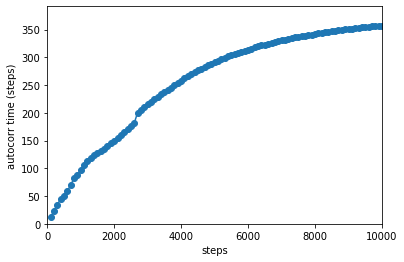

In [9]:
# load the backend
reader = emcee.backends.HDFBackend(h5_filename)

# set burn-in
burnin = 2000     # if you know it from previous checks!

# set parameter labels
lbls = ['F', 'rt', 'log(alpha)', 'beta', 'gamma', 'i', 'PA', 'dx', 'dy']

# parse the samples
all_samples = reader.get_chain(discard=0, flat=False)
samples = reader.get_chain(discard=burnin, flat=False)
nsteps, nwalk, ndim = samples.shape[0], samples.shape[1],  samples.shape[2]

# plot the integrated autocorrelation time convergence every Ntau steps
Ntau = 100
Nmax = all_samples.shape[0]
if (Nmax > Ntau):
    tau_ix = np.empty(np.int(Nmax / Ntau))
    ix = np.empty(np.int(Nmax / Ntau))
    for i in range(len(tau_ix)):
        nn = (i + 1) * Ntau
        ix[i] = nn
        tau = emcee.autocorr.integrated_time(all_samples[:nn,:,:], tol=0)
        tau_ix[i] = np.mean(tau)

    plt.plot(ix, tau_ix, '-o')
    plt.xlabel('steps')
    plt.ylabel('autocorr time (steps)')
    plt.xlim([0, Nmax])
    plt.ylim([0, tau_ix.max() + 0.1 * (tau_ix.max() - tau_ix.min())])

Next, I usually look at the traces (i.e., how the chains move in parameter space as a function of the step).  Sometimes it is just 1 parameter that is causing havoc and preventing convergence...and then its obvious in the trace.  One can go back and tweak the prior on that parameter, if that seems helpful.  Another option might be to experiment with emcee moves (we can discuss).  But usually this should only happen if you're fitting awful data (perhaps that will be the case...e.g., low resolution wrt emission extent and/or low SNR).  In that scenario, it is worthwhile to consider a simpler model (we can discuss that too).

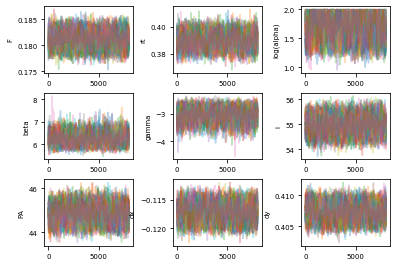

In [10]:
# plot the traces
fig = plt.figure(figsize=(6, 3.5))
for idim in np.arange(ndim):
    plt.subplot(3, 3, idim+1)
    for iw in np.arange(nwalk):
        plt.plot(np.arange(nsteps), samples[:, iw, idim], alpha=0.3)
        plt.ylabel(lbls[idim], fontsize=7)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
fig.subplots_adjust(wspace=0.45, hspace=0.3)
fig.subplots_adjust(left=0.10, right=0.90, bottom=0.04, top=0.99)

Finally, it is important and useful to look at the parameter covariances.  (I apologize: I do not know why it shows this twice.)

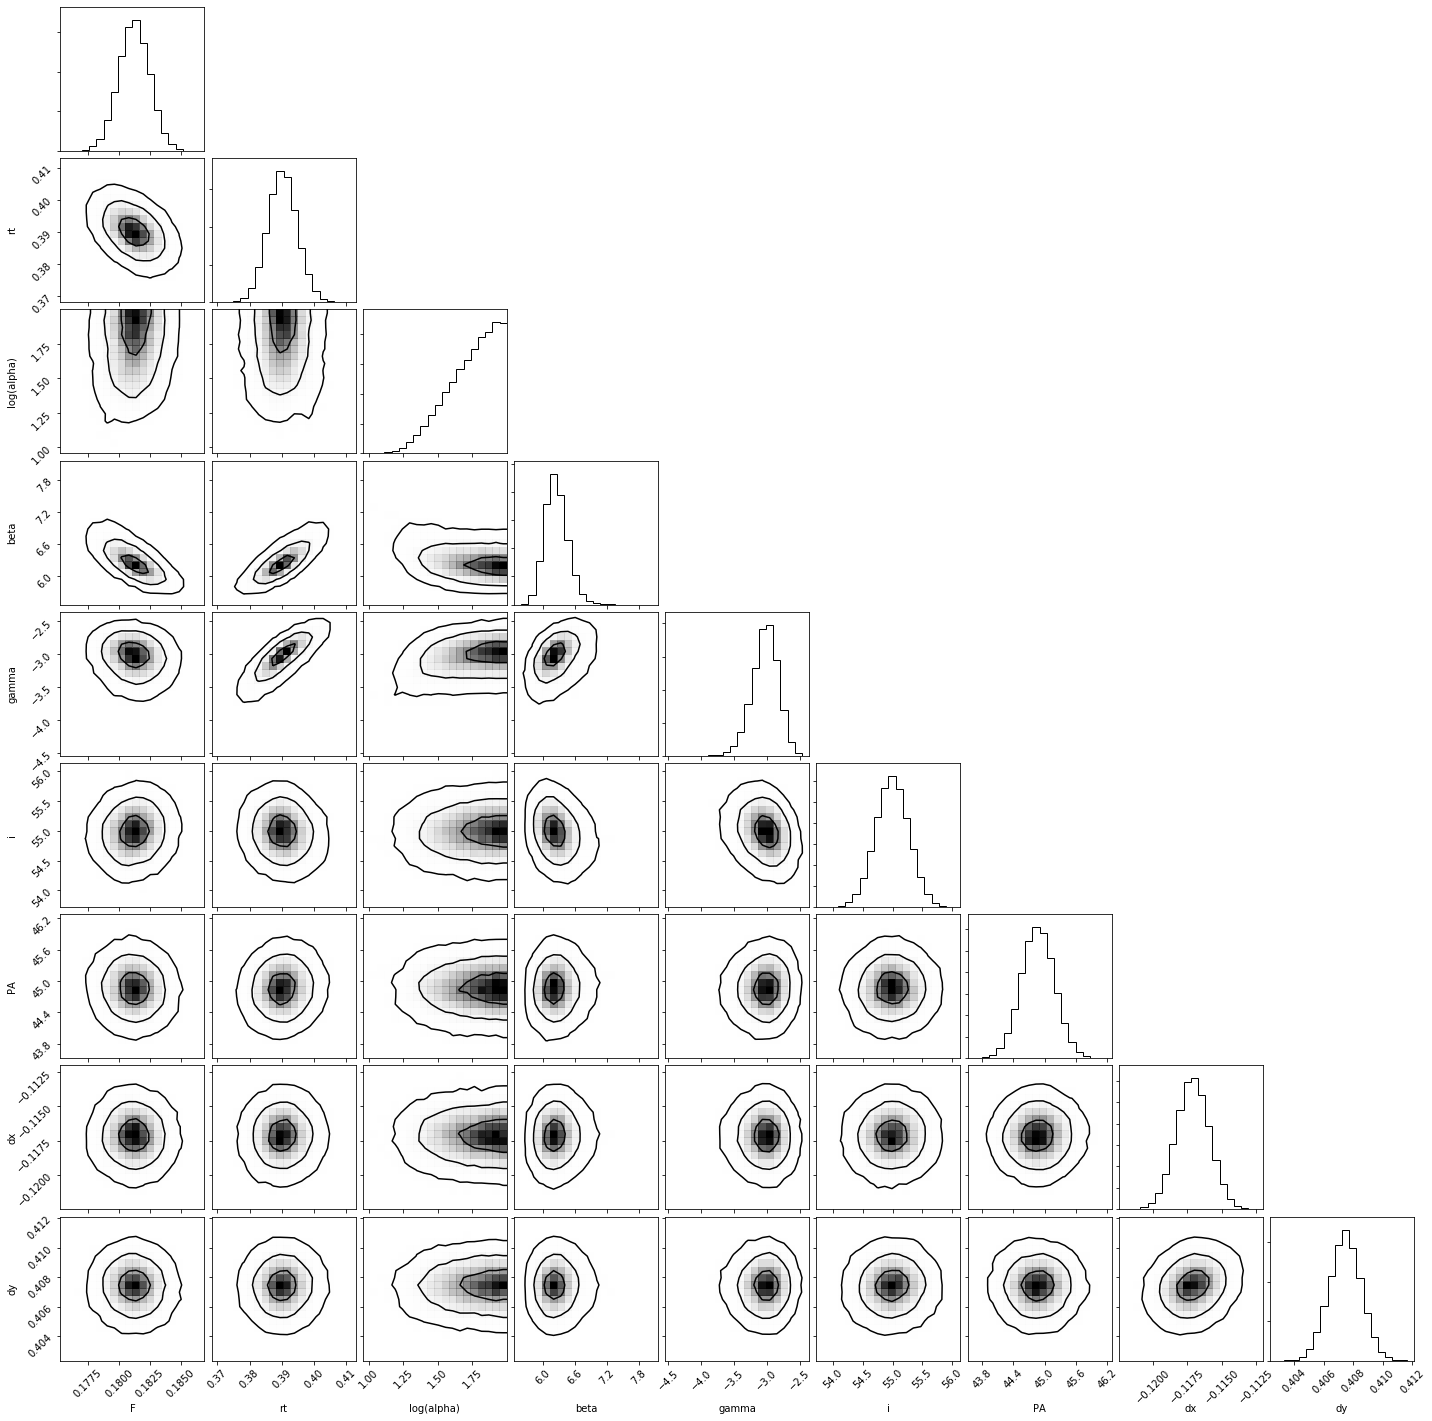

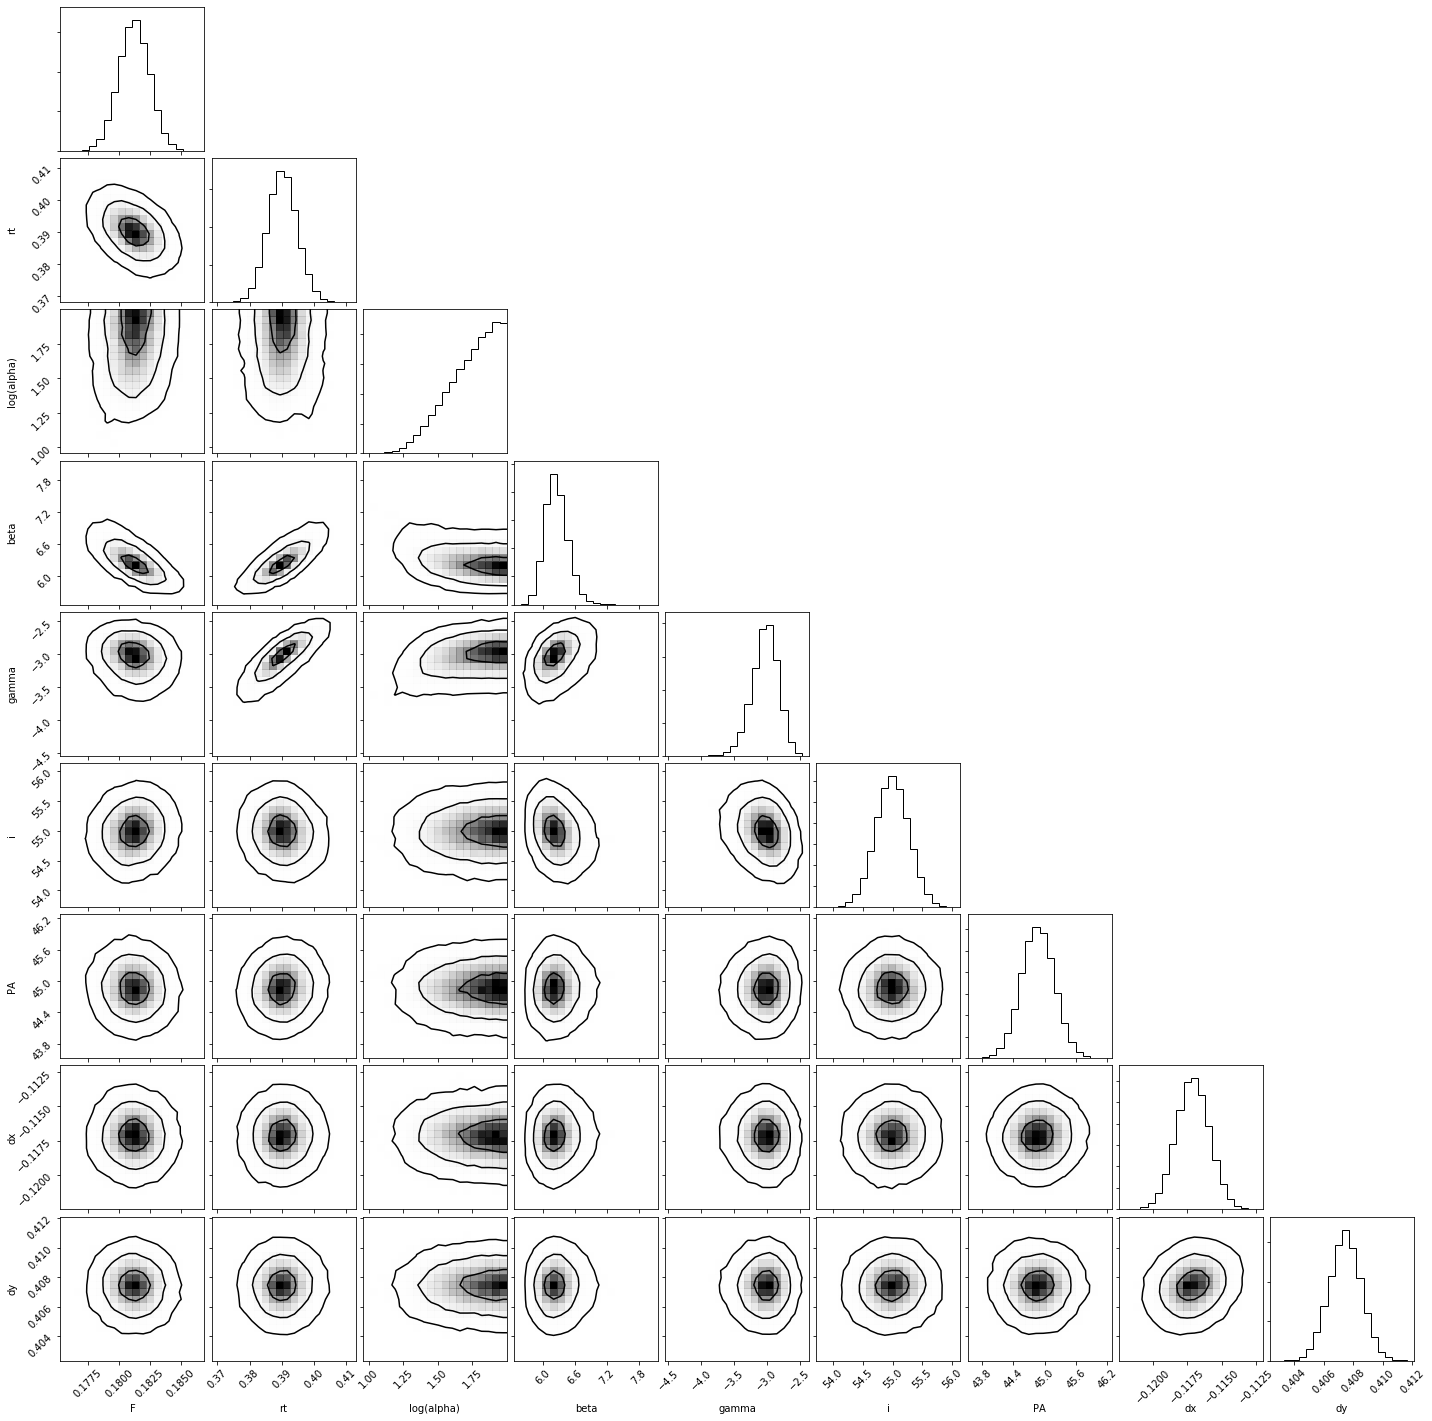

In [11]:
# corner plot to view covariances
levs = 1. - np.exp(-0.5*(np.arange(3)+1)**2)
flat_chain = samples.reshape(-1, ndim)
corner.corner(flat_chain, plot_datapoints=False, levels=levs, labels=lbls) 

Once satisfied that you've converged and assessed the burn-in duration, you can quantify the posterior inferences in the standard way.  For the "best" parameters, I like to use the peaks of the marginal posterior distributions, rather than their medians (which are not the "best" if the distribution is asymmetric).  I do that with a simple kernel density estimator.  You can also retrieve limits as appropriate (e.g., for $\alpha$).

In [14]:
# this function returns the "best" parameters (peak of the marginal posteriors) 
# and the +/- 68.3% confidence intervals.  You can also set it to give upper or lower bounds.
# for example, to get a ~2-sigma upper limit, set lim=0.955; a 2-sigma lower limit, set lim=0.045
from scipy import stats
def post_summary(p, prec=0.1, mu='peak', lim=None, CIlevs=[84.135, 15.865]):

    if not lim == None:
        return np.percentile(p, lim)
    
    # calculate percentiles as designated
    CI_p = np.percentile(p, CIlevs)

    # find peak of posterior
    if (mu == 'peak'):
        kde_p = stats.gaussian_kde(p)
        ndisc = np.int(np.round((CI_p[0] - CI_p[1]) / prec))
        x_p = np.linspace(CI_p[1], CI_p[0], ndisc)
        pk_p = x_p[np.argmax(kde_p.evaluate(x_p))]
    else:
        pk_p = np.percentile(p, 50.)

    # return the peak and upper, lower 1-sigma
    return (pk_p, CI_p[0]-pk_p, pk_p-CI_p[1])


# read in the chain again, flatten and thin it
pp = reader.get_chain(discard=burnin, thin=350, flat=True)

# look at the corner plots; you can see what you need for each parameter.
# you could do a loop here, but this should be sufficient:
print('Fnu = %6.4f +%6.4f / -%6.4f Jy' % (post_summary(pp[:,0], prec=0.0001)))
print('r_t = %5.3f +%5.3f / -%5.3f arcsec' % (post_summary(pp[:,1], prec=0.001)))
print('log alpha >= %4.2f' % (post_summary(pp[:,2], lim=0.045)))
print('beta = %3.1f +%3.1f / -%3.1f' % (post_summary(pp[:,3])))
print('gamma = %3.1f +%3.1f / -%3.1f' % (post_summary(pp[:,4])))
print('i = %4.1f +%4.1f / -%4.1f degrees' % (post_summary(pp[:,5])))
print('PA = %4.1f +%4.1f / -%4.1f degrees' % (post_summary(pp[:,6])))
print('dx = %5.4f +%5.4f / -%5.4f arcsec' % (post_summary(pp[:,7], prec=0.0001)))
print('dy = %5.4f +%5.4f / -%5.4f arcsec' % (post_summary(pp[:,8], prec=0.0001)))

Fnu = 0.1811 +0.0013 / -0.0012 Jy
r_t = 0.391 +0.003 / -0.006 arcsec
log alpha >= 1.08
beta = 6.2 +0.3 / -0.1
gamma = -3.0 +0.1 / -0.2
i = 54.9 + 0.3 / - 0.2 degrees
PA = 44.8 + 0.4 / - 0.3 degrees
dx = -0.1172 +0.0014 / -0.0010 arcsec
dy = 0.4072 +0.0012 / -0.0008 arcsec


And finally, we do some post-processing of the posterior samples to get at some quantities of interest.  First we calculate the intensity profiles for each (independent) posterior sample.  Then we convert those into cumulative flux profiles ($f_\nu(\le \varrho) = \int_0^\varrho I_\nu(\varrho^\prime) \, 2\pi \, \varrho^\prime \, d\varrho^\prime$).  A simple interpolation of those profiles is used to compute posterior samples of the effective radii of interest (e.g., at 68% or 90% of the total luminosity).  All of those things are saved for future use in a numpy save file. 

In [15]:
import scipy.integrate as sci
from scipy.interpolate import interp1d

# copy the radial bin locations code from the vis_model function
nbins = 150
b = np.logspace(-3, 1, num=nbins)
a = np.roll(b, 1)
rin = 0.1 / 140.
a[0] = rin
cb = 0.5 * (a + b)

# now we're going to compute an array of un-normalized intensity profiles, one for each posterior sample
# the result will be an (nsteps x nbins) array
xr  = np.outer(1 / pp[:,1], cb)
gam = (np.tile(pp[:,4], (nbins, 1))).transpose()
alp = (np.tile(10**pp[:,2], (nbins, 1))).transpose()
idx = (np.tile((pp[:,4] - pp[:,3]) / (10**pp[:,2]), (nbins, 1))).transpose()
SB  = xr**(-gam) * (1 + xr**alp)**idx

# next, we integrate that array at each radius to get cumulative flux profiles (f(<r) in our paper)
Fcum = sci.cumtrapz(2 * np.pi * SB * cb, cb, initial=0., axis=1)

# then we can normalize those cumulative flux profiles
Ftot = (np.tile(Fcum[:,nbins-1], (nbins, 1))).transpose()
nFcum = Fcum / Ftot

# and normalize the surface brightness profiles
SB *= (np.tile(pp[:,0] / Fcum[:,nbins-1], (nbins, 1))).transpose()

# calculate size(s) as you like
Reff68 = np.empty(pp.shape[0])
Reff90 = np.empty(pp.shape[0])
Reff95 = np.empty(pp.shape[0])
for i in range(pp.shape[0]):
    fint = interp1d(nFcum[i,:], cb)
    Reff68[i] = fint(0.68)
    Reff90[i] = fint(0.90)
    Reff95[i] = fint(0.95)

# for plotting purposes, you might want to save confidence intervals of the SB & fcum profile posteriors
SBpost = np.percentile(SB, [2.5, 16, 50, 84, 97.5], axis=0)
FRpost = np.percentile(nFcum, [2.5, 16, 50, 84, 97.5], axis=0)

# save for future use
np.savez(target+'.ppost.npz', radius=cb, SB=SBpost, Fcum=FRpost,
         Ftot=pp[:,0], Reff68=Reff68, Reff90=Reff90, Reff95=Reff95)

# and print out the effective size posterior inference
print('reff_68 = %5.3f +%5.3f / -%5.3f arcsec' % (post_summary(Reff68, prec=0.001)))
print('reff_90 = %5.3f +%5.3f / -%5.3f arcsec' % (post_summary(Reff90, prec=0.001)))

reff_68 = 0.445 +0.003 / -0.003 arcsec
reff_90 = 0.585 +0.010 / -0.009 arcsec
